# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import catboost
from sklearn.metrics import mean_squared_error

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
display(taxi.head())
display(taxi.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

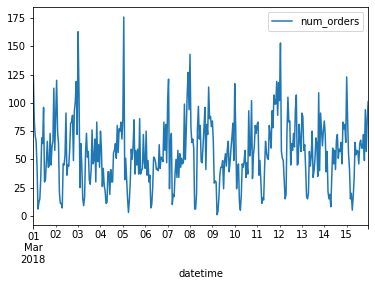

In [4]:
taxi['2018-03-01': '2018-03-15'].plot()
plt.show()

In [5]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

 
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [6]:
make_features(taxi, 3, 4)
display(taxi.head(10))
print(taxi.shape)
taxi_features = taxi.dropna()
print(taxi_features.shape)

,num_orders,year,month,day,hour,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,0,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,2,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,2018,3,1,4,3,66.0,71.0,85.0,86.50
2018-03-01 05:00:00,6,2018,3,1,5,3,43.0,66.0,71.0,66.25
2018-03-01 06:00:00,12,2018,3,1,6,3,6.0,43.0,66.0,46.50
2018-03-01 07:00:00,15,2018,3,1,7,3,12.0,6.0,43.0,31.75
2018-03-01 08:00:00,34,2018,3,1,8,3,15.0,12.0,6.0,19.00


(4416, 10)
(4412, 10)


## Analysis

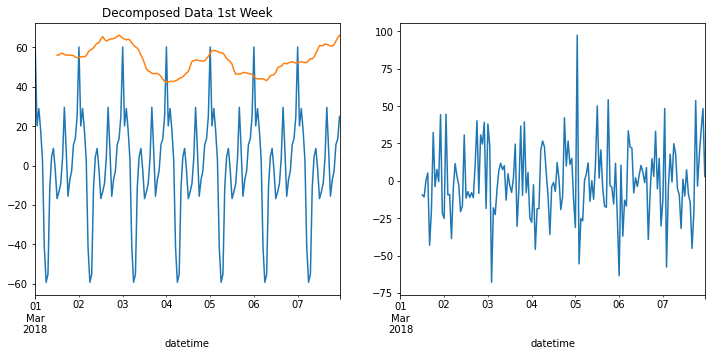

In [7]:
decomposed = seasonal_decompose(taxi['num_orders'])
plt.figure(figsize = (12,5))
plt.subplot(121)
decomposed.seasonal['2018-03-01': '2018-03-7'].plot()
decomposed.trend['2018-03-01': '2018-03-7'].plot()
plt.title('Decomposed Data 1st Week')
plt.subplot(122)
decomposed.resid['2018-03-01': '2018-03-7'].plot()
plt.show()


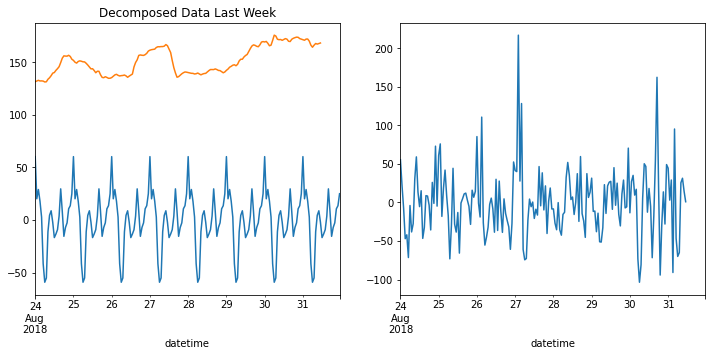

In [8]:
plt.figure(figsize = (12,5))
plt.subplot(121)
decomposed.seasonal['2018-08-24': '2018-08-31'].plot()
decomposed.trend['2018-08-24': '2018-08-31'].plot()
plt.title('Decomposed Data Last Week')
plt.subplot(122)
decomposed.resid['2018-08-24': '2018-08-31'].plot()
plt.show()


<AxesSubplot:xlabel='datetime'>

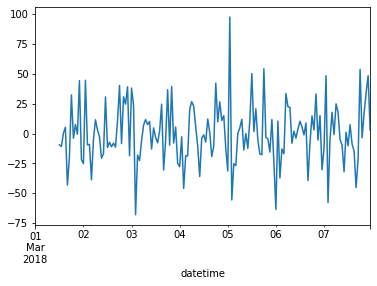

In [9]:
decomposed.resid['2018-03-01': '2018-03-7'].plot()

<AxesSubplot:xlabel='datetime'>

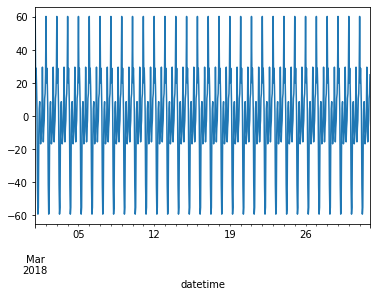

In [10]:
decomposed.seasonal['2018-03-01': '2018-03-31'].plot()

<AxesSubplot:xlabel='datetime'>

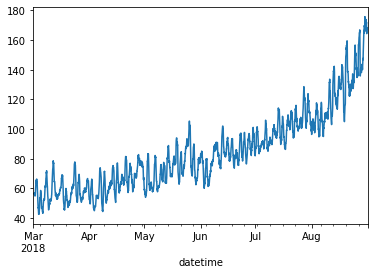

In [11]:
decomposed.trend.plot()

I focused on the first week of March and the last week of August to visualize the seasonality of the data. There is a lot of noise in the residual values but there is a repetitive trend that is consistant each day. Looking at the overall trend of the data the amount of taxi orders increased from March to August. 

## Training

In [12]:
train, test = train_test_split(taxi_features, test_size = 0.1, random_state = 12345)
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']
print(train_features.shape)
print(train_target.shape)
print(test_features.shape)
print(test_target.shape)

(3970, 9)
(3970,)
(442, 9)
(442,)


In [13]:
dec_tree_score = -48
dec_tree_depth = 0

for depth in range(1,20):
    dec_tree = DecisionTreeRegressor(max_depth = depth, random_state = 12345)
    dec_tree_results = cross_val_score(dec_tree, train_features, train_target, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
    if dec_tree_results > dec_tree_score:
        dec_tree_score = dec_tree_results
        dec_tree_depth = depth
        
print(-dec_tree_score)
print(dec_tree_depth)


29.793151841511463
6


In [14]:
ran_for_score = -48
ran_for_depth = 0

for depth in range(13,20):
    ran_for = RandomForestRegressor(max_depth = depth, random_state = 12345)
    ran_for_results = cross_val_score(ran_for, train_features, train_target, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
    if ran_for_results > ran_for_score:
        ran_for_score = ran_for_results
        ran_for_depth = depth
        
print(-ran_for_score)
print(ran_for_depth)


25.26684688660438
13


In [15]:
cb_model = catboost.CatBoostRegressor()
cb_model.fit(train_features, train_target)

Learning rate set to 0.050908
0:	learn: 43.9267298	total: 53.6ms	remaining: 53.6s
1:	learn: 42.9070218	total: 56.3ms	remaining: 28.1s
2:	learn: 41.9574437	total: 58.8ms	remaining: 19.5s
3:	learn: 40.9823404	total: 61.2ms	remaining: 15.2s
4:	learn: 40.0937953	total: 63.6ms	remaining: 12.7s
5:	learn: 39.2048055	total: 66.1ms	remaining: 10.9s
6:	learn: 38.4066610	total: 68.4ms	remaining: 9.7s
7:	learn: 37.6882240	total: 70.7ms	remaining: 8.77s
8:	learn: 37.1603389	total: 73ms	remaining: 8.04s
9:	learn: 36.6021079	total: 75.3ms	remaining: 7.46s
10:	learn: 36.0202846	total: 77.6ms	remaining: 6.97s
11:	learn: 35.4973359	total: 79.9ms	remaining: 6.58s
12:	learn: 34.9747383	total: 82.7ms	remaining: 6.28s
13:	learn: 34.4036991	total: 85.3ms	remaining: 6.01s
14:	learn: 33.9162709	total: 87.8ms	remaining: 5.76s
15:	learn: 33.5553151	total: 90.2ms	remaining: 5.55s
16:	learn: 33.1871216	total: 93ms	remaining: 5.38s
17:	learn: 32.7786144	total: 99.9ms	remaining: 5.45s
18:	learn: 32.3886547	total: 10

## Testing

In [16]:
dec_tree = DecisionTreeRegressor(max_depth = 6, random_state = 12345)
dec_tree.fit(train_features, train_target)
dec_tree_predict = dec_tree.predict(test_features)
dec_tree_score = (mean_squared_error(dec_tree_predict, test_target))**0.5
print(dec_tree_score)

27.227891308960675


In [17]:
ran_for = RandomForestRegressor(max_depth = 13, random_state = 12345)
ran_for.fit(train_features, train_target)
ran_for_predict = ran_for.predict(test_features)
ran_for_score = (mean_squared_error(ran_for_predict, test_target))**0.5
print(ran_for_score)

23.584072637614767


In [18]:
cb_predict = cb_model.predict(test_features)
cb_score = (mean_squared_error(cb_predict, test_target))**0.5
print(cb_score)

21.373226178058804


## Conclusion

There appears to be seasonality in the data, where there are several peaks throughout the day and is consistant from day to day. The overall trend in the data is a increasing number of taxi orders. 

I compared DicisionTreeRegressor, RandomForrestRegressor, and CatBoost. All of the models scored under the threshold on the test dataset, but CatBoost was the lowest with a score of 21.37. 